In [54]:
import numpy as np
from numpy import unique
from numpy import where
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame
from sklearn.cluster import KMeans
from sklearn import datasets
import sklearn.cluster as skl_cluster
import sklearn.datasets.samples_generator as skl_smpl
from matplotlib import pyplot as plt

In [55]:
import pandas as pd
from sklearn import datasets
wine = datasets.load_wine()
data = pd.DataFrame(wine.data)
data.columns = wine.feature_names
data['Type']=wine.target
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Type
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [56]:
X_data = data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]].values
Y_data=data['Type']
Y_data = np.array(Y_data)

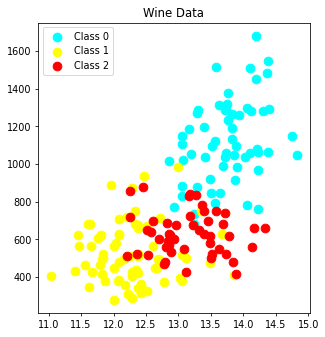

In [57]:
plt.scatter(X_data[Y_data == 0, 0], X_data[Y_data == 0, 12], s = 80, c = 'cyan', label = 'Class 0')
plt.scatter(X_data[Y_data == 1, 0], X_data[Y_data == 1, 12], s = 80, c = 'yellow', label = 'Class 1')
plt.scatter(X_data[Y_data == 2, 0], X_data[Y_data == 2, 12], s = 80, c = 'red', label = 'Class 2')

plt.title("Wine Data")
plt.legend()

In [79]:
class KerKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, centroids=3, loop=50, cap=1e-3, random_state=None,
                 kernel="poly", gamma=0.01, degree=3, df=1,
                 vals=None, backG=0):
        self.centroids = centroids
        self.loop = loop
        self.cap = cap
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.df = df
        self.vals = vals
        self.backG = backG
        
    def KernelComputation(self, X, Y=None):
        if callable(self.kernel):
            kernel_values = self.vals or {}
        else:
            kernel_values = {"gamma": self.gamma,
                      "degree": self.degree,
                      "df": self.df}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **kernel_values)

    def fit(self, X, y=None, wt=None):
        total = X.shape[0]
        
        K = self.KernelComputation(X)
        WithinS = wt if wt else np.ones(total)
        self.wt = WithinS
        
        self_rand = check_random_state(self.random_state)
        self.labels_ = self_rand.randint(self.centroids, size=total)
        dist = np.zeros((total, self.centroids))
        self.Distance_matrix_within = np.zeros(self.centroids)
        for it in range(self.loop):
            dist.fill(0)
            self.EqdDistance(K, dist, self.Distance_matrix_within,check=True)
            predicts1 = self.labels_
            self.labels_ = dist.argmin(axis=1)           
            pq = np.sum((self.labels_ - predicts1) == 0)
            if 1 - float(pq) / total < self.cap:
                if self.backG:
                    print ("Done", it + 1)
                break

        self.X_fit_ = X
        return self

    def EqdDistance(self, K, dist, within_distances, check):
        WithinS = self.wt
        for j in range(self.centroids):
            fk = self.labels_== j
            if np.sum(fk) == 0:
                raise ValueError("Data not found in cluster")
            A = WithinS[fk].sum()
            Asquare = A * A
            if check:
                Ksquare = K[fk][:, fk]  
                dist_j = np.sum(np.outer(WithinS[fk], WithinS[fk]) * Ksquare / Asquare)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(WithinS[fk] * K[:, fk], axis=1) / A
    @property
    def KernelPair(self):
        return self.kernel == "precomputed"
    def predict(self, X):
        A = self.KernelComputation(X, self.X_fit_)
        total = X.shape[0]
        XX = np.zeros((total, self.centroids))
        self.EqdDistance(A, XX, self.Distance_matrix_within,
                           check=False)
        return XX.argmin(axis=1)

In [80]:
if __name__ == '__main__':
    from sklearn.datasets import make_blobs


Text(0.5, 1.0, 'K means clustering on Wine Data')

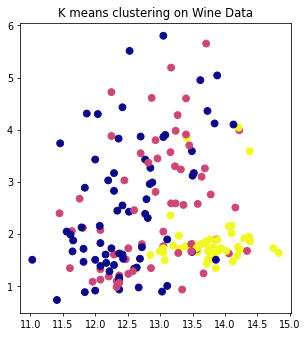

In [81]:
#Standard K means 
Kmean = skl_cluster.KMeans(n_clusters=3)
Kmean.fit(X_data)
clusters_wine = Kmean.predict(X_data)

#plotting After K means Data 
plt.scatter(X_data[:, 0], X_data[:, 1], c=clusters_wine, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':100})
plt.title("K means clustering on Wine Data")

In [82]:
from sklearn.metrics import accuracy_score
print("Accuracy: %0.2f" % accuracy_score(Y_data,clusters_wine))

Accuracy: 0.11


In [83]:
#Kernalized K means
km = KerKMeans(centroids=3, loop=100, random_state=0, backG=1)
print (km.fit_predict(X_data)[:10])
print (km.predict(X_data[:10]))
yhat_wine=km.predict(X_data)

Done 8
[0 0 0 1 2 1 1 1 0 0]
[0 0 0 1 2 1 1 1 0 0]


Text(0.5, 1.0, 'Kernel K-means clustering on Wine Data')

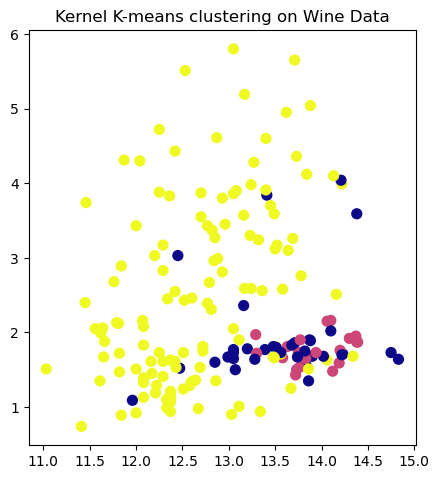

In [84]:
plt.scatter(X_data[:, 0], X_data[:, 1], c=yhat_wine, s=50, cmap='plasma')
plt.rcParams.update({'figure.figsize':(5,5.5), 'figure.dpi':70})
plt.title("Kernel K-means clustering on Wine Data")

In [85]:
from sklearn.metrics import accuracy_score
print("Accuracy: %0.2f" % accuracy_score(Y_data,yhat_wine))

Accuracy: 0.43
